In [1]:
"""
Earthquake Risk Assessment Using USGS Data and Sampling Methods
=================================================================

This section estimates the tail probability of earthquake magnitudes (M >= M_crit)
using three sampling techniques:

    1. Standard Monte Carlo Sampling
    2. Importance Sampling
    3. Stratified Sampling

We use public earthquake data from the USGS Earthquake Catalog, fit an exponential
distribution to the magnitudes,and compare the efficiency of the sampling methods
in estimating the probability that an earthquake's magnitude exceeds a critical
threshold (e.g., M_crit = 6.5).
"""

"\nEarthquake Risk Assessment Using USGS Data and Sampling Methods\n=================================================================\n\nThis section estimates the tail probability of earthquake magnitudes (M >= M_crit)\nusing three sampling techniques:\n\n    1. Standard Monte Carlo Sampling\n    2. Importance Sampling\n    3. Stratified Sampling\n\nWe use public earthquake data from the USGS Earthquake Catalog, fit an exponential\ndistribution to the magnitudes,and compare the efficiency of the sampling methods \nin estimating the probability that an earthquake's magnitude exceeds a critical \nthreshold (e.g., M_crit = 6.5).\n"

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import expon
import time

In [3]:
np.random.seed(42)

Number of earthquakes after filtering (M >= 4.0): 869


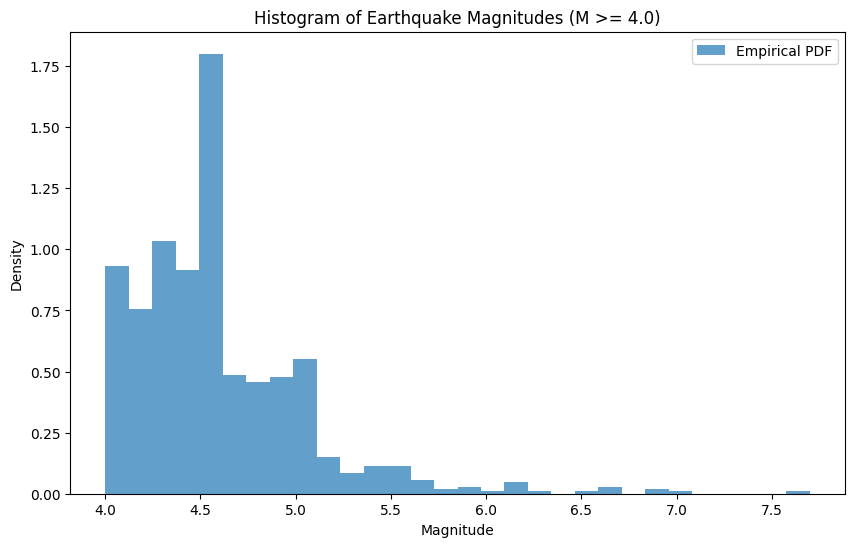

In [4]:
data_url = "https://earthquake.usgs.gov/earthquakes/feed/v1.0/summary/2.5_month.csv"
df = pd.read_csv(data_url)

df = df[df['mag'] >= 4.0].reset_index(drop=True)
print("Number of earthquakes after filtering (M >= 4.0):", len(df))

magnitudes_empirical = df['mag'].values

plt.figure(figsize=(10, 6))
plt.hist(magnitudes_empirical, bins=30, density=True, alpha=0.7, label='Empirical PDF')
plt.xlabel('Magnitude')
plt.ylabel('Density')
plt.title('Histogram of Earthquake Magnitudes (M >= 4.0)')
plt.legend()
plt.show()

Estimated lambda (rate) of exponential model: 1.7117418795674355


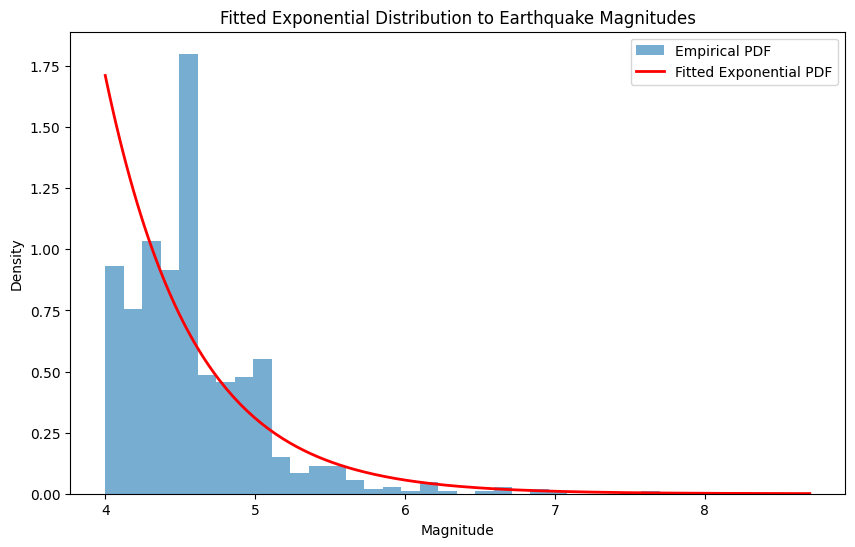

In [5]:
"""
We assume a simplified model where the magnitudes follow an exponential distribution
shifted by a minimum magnitude M_min. That is, for M >= M_min:

    p(M) = lambda * exp[-lambda * (M - M_min)]

We set M_min = 4.0 (our filtering threshold) and estimate lambda using the MLE:
    lambda_hat = 1 / mean(M - M_min)
"""

M_min = 4.0
lambda_hat = 1 / np.mean(magnitudes_empirical - M_min)
print("Estimated lambda (rate) of exponential model:", lambda_hat)

def p_fitted(M):
    return lambda_hat * np.exp(-lambda_hat * (M - M_min)) if M >= M_min else 0

M_plot = np.linspace(M_min, np.max(magnitudes_empirical) + 1, 200)
pdf_fitted = [p_fitted(M) for M in M_plot]

plt.figure(figsize=(10, 6))
plt.hist(magnitudes_empirical, bins=30, density=True, alpha=0.6, label='Empirical PDF')
plt.plot(M_plot, pdf_fitted, 'r-', lw=2, label='Fitted Exponential PDF')
plt.xlabel('Magnitude')
plt.ylabel('Density')
plt.title('Fitted Exponential Distribution to Earthquake Magnitudes')
plt.legend()
plt.show()

In [6]:
"""
We define our risk metric as the tail probability:
    P(M >= M_crit) = ∫[M_crit,∞] p(M) dM

For the fitted exponential distribution, this can be computed analytically as:
    P(M >= M_crit) = exp[-lambda_hat * (M_crit - M_min)]

We set M_crit = 6.5.
"""
M_crit = 6.5
true_tail_prob = np.exp(-lambda_hat * (M_crit - M_min))
print(f"Analytical tail probability (P(M >= {M_crit})): {true_tail_prob:.4f}")

Analytical tail probability (P(M >= 6.5)): 0.0139


In [7]:
def mc_tail_probability(N):
    """
    Standard Monte Carlo estimator:
    Sample M from the fitted exponential distribution using inverse transform sampling.
    Estimate tail probability as the fraction of samples with M >= M_crit.
    """
    u = np.random.uniform(0, 1, size=N)
    samples = M_min - (1 / lambda_hat) * np.log(1 - u)
    return np.mean(samples >= M_crit)

N_samples = 10000
mc_est = mc_tail_probability(N_samples)
print(f"MC Tail Probability estimate with {N_samples} samples: {mc_est:.4f}")

MC Tail Probability estimate with 10000 samples: 0.0121


In [8]:
def is_tail_probability(N, lambda_q):
    """
    Importance Sampling estimator:
    - For a sample M drawn from q, the weight is w = p(M) / q(M).
    - The tail probability estimate is the weighted average of the indicator I(M >= M_crit).
    """
    u = np.random.uniform(0, 1, size=N)
    samples = M_min - (1 / lambda_q) * np.log(1 - u)

    weights = (lambda_hat / lambda_q) * np.exp(-(lambda_hat - lambda_q) * (samples - M_min))

    indicators = (samples >= M_crit).astype(float)
    return np.mean(indicators * weights)

lambda_q = lambda_hat / 2
is_est = is_tail_probability(N_samples, lambda_q)
print(f"Importance Sampling Tail Probability estimate with {N_samples} samples: {is_est:.4f}")


Importance Sampling Tail Probability estimate with 10000 samples: 0.0144


In [9]:
def stratified_tail_probability(N, num_strata):
    """
    Stratified Sampling estimator:
    - Partition the uniform sample space [0,1] into num_strata equal intervals.
    - The estimator is simply the fraction of these stratified samples that exceed M_crit.
    """
    u_strata = np.linspace(0, 1, num_strata + 1)
    u_mid = (u_strata[:-1] + u_strata[1:]) / 2.0
    samples = M_min - (1 / lambda_hat) * np.log(1 - u_mid)
    return np.mean(samples >= M_crit)

num_strata = 100
ss_est = stratified_tail_probability(N_samples, num_strata)
print(f"Stratified Sampling Tail Probability estimate with {num_strata} strata: {ss_est:.4f}")

Stratified Sampling Tail Probability estimate with 100 strata: 0.0100


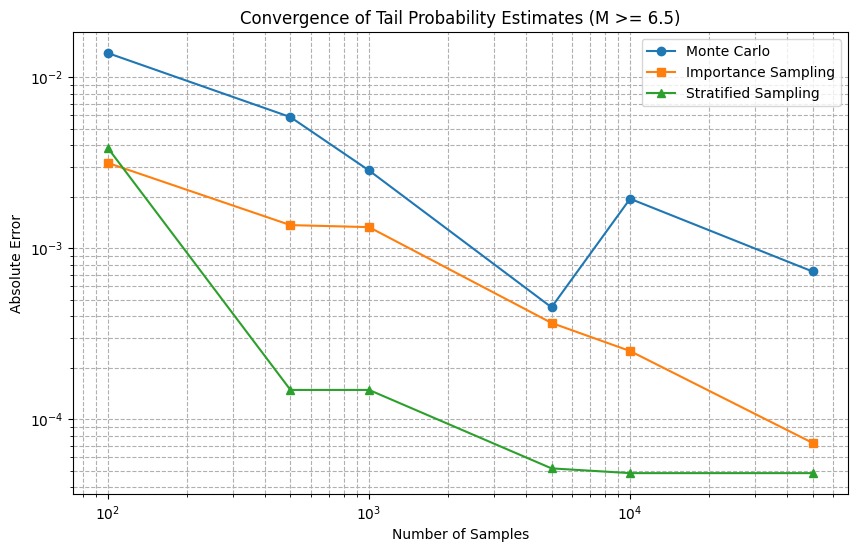

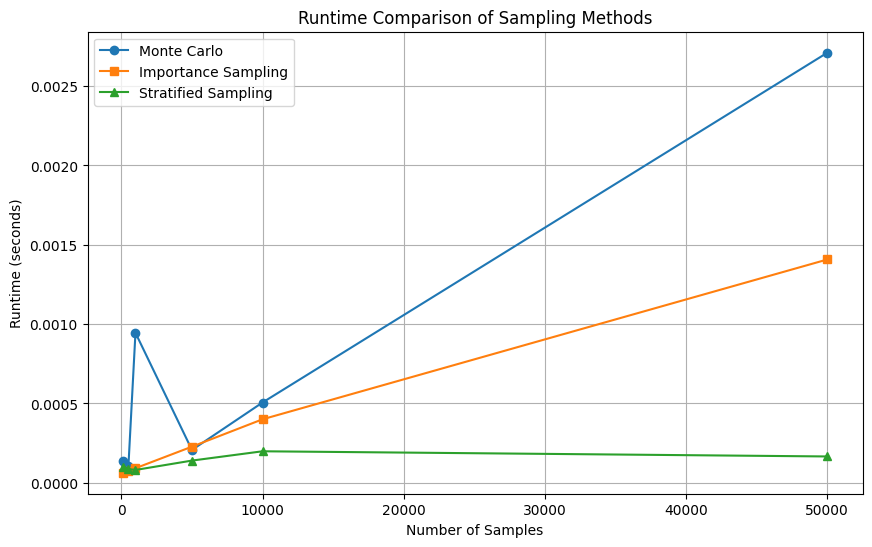

In [10]:
sample_sizes = [100, 500, 1000, 5000, 10000, 50000]
mc_errors, is_errors, ss_errors = [], [], []
mc_times, is_times, ss_times = [], [], []

for N in sample_sizes:
    # Standard Monte Carlo
    start = time.time()
    est_mc = mc_tail_probability(N)
    mc_times.append(time.time() - start)
    mc_errors.append(abs(est_mc - true_tail_prob))

    # Importance Sampling
    start = time.time()
    est_is = is_tail_probability(N, lambda_q)
    is_times.append(time.time() - start)
    is_errors.append(abs(est_is - true_tail_prob))

    # Stratified Sampling
    num_strata = N if N < 10000 else 10000
    start = time.time()
    est_ss = stratified_tail_probability(N, num_strata)
    ss_times.append(time.time() - start)
    ss_errors.append(abs(est_ss - true_tail_prob))

# Plot convergence of error vs. sample size
plt.figure(figsize=(10, 6))
plt.loglog(sample_sizes, mc_errors, 'o-', label='Monte Carlo')
plt.loglog(sample_sizes, is_errors, 's-', label='Importance Sampling')
plt.loglog(sample_sizes, ss_errors, '^-', label='Stratified Sampling')
plt.xlabel('Number of Samples')
plt.ylabel('Absolute Error')
plt.title(f'Convergence of Tail Probability Estimates (M >= {M_crit})')
plt.legend()
plt.grid(True, which='both', ls='--')
plt.show()

# Plot runtime comparison
plt.figure(figsize=(10, 6))
plt.plot(sample_sizes, mc_times, 'o-', label='Monte Carlo')
plt.plot(sample_sizes, is_times, 's-', label='Importance Sampling')
plt.plot(sample_sizes, ss_times, '^-', label='Stratified Sampling')
plt.xlabel('Number of Samples')
plt.ylabel('Runtime (seconds)')
plt.title('Runtime Comparison of Sampling Methods')
plt.legend()
plt.grid(True)
plt.show()

In [11]:
"""
Conclusions:

 - Using standard Monte Carlo sampling, we estimate the tail probability by generating samples
   from the fitted model via inverse transform sampling.

 - Importance Sampling leverages a modified exponential distribution to
   oversample the tail region. We then weight the samples accordingly to obtain the estimate.

 - Stratified Sampling partitions the uniform sampling space into equal strata and uses the midpoints
   as representative samples. This method can reduce variance by ensuring a uniform coverage over the
   entire probability space.

 - The convergence plots and runtime comparisons demonstrate the trade-offs:
   - While all methods converge as the sample size increases, some (like Importance Sampling) may achieve
     lower error with fewer samples in the tail region.
   - Runtime differences are also visible, helping decide which method is best for a given computational
     budget and risk assessment scenario.

This section illustrates how advanced sampling techniques can be applied to real-world seismic data
to estimate critical risk metrics, thereby contributing valuable insights to earthquake risk management.
"""

'\nConclusions:\n-------------\n1. The analytical tail probability, based on our fitted exponential model, is:\n       P(M >= {M_crit}) = {true_tail_prob:.4f}\n\n2. Using standard Monte Carlo sampling, we estimate the tail probability by generating samples\n   from the fitted model via inverse transform sampling.\n\n3. Importance Sampling leverages a modified exponential distribution (with a lower rate, lambda_q)\n   to oversample the tail region. We then weight the samples accordingly to obtain the estimate.\n\n4. Stratified Sampling partitions the uniform sampling space into equal strata and uses the midpoints\n   as representative samples. This method can reduce variance by ensuring a uniform coverage over the\n   entire probability space.\n\n5. The convergence plots and runtime comparisons demonstrate the trade-offs:\n   - While all methods converge as the sample size increases, some (like Importance Sampling) may achieve\n     lower error with fewer samples in the tail region.\n  